# PRE-PROCESSING THE DATA

In [ ]:
pip install tqdm

In [ ]:
import pandas as pd
import os

def loadCrimeData():
    crime_data = pd.read_csv('ML_Crime_Data.csv')
    return crime_data

crime_data = loadCrimeData()

# check size (in terms of MB)
file_info = os.stat('ML_Crime_Data.csv')
size_in_MB = file_info.st_size / (1024 * 1024)
print(f"Size of the dataset: {size_in_MB:.2f} MB")

# check the number of entries and features
num_entries, num_features = crime_data.shape
print(f"Number of entries: {num_entries}")
print(f"Number of features: {num_features}")

# check for categorical data
categorical_features = crime_data.select_dtypes(include=['object']).columns
print(f"Number of categorical features: {len(categorical_features)}")

# check for missing values
missing_values = crime_data.isnull().sum()
num_missing = missing_values[missing_values > 0].shape[0]
print(f"Number of features with missing values: {num_missing}")

# basic statistics
print("\nBasic statistics for the dataset:")
print(crime_data.describe())

Size of the dataset: 3.78 MB
Number of entries: 24632
Number of features: 12
Number of categorical features: 6
Number of features with missing values: 2

Basic statistics for the dataset:
           RecordID    IncidentID   BlockNumber  HourReported      Latitude  \
count  24632.000000  2.463200e+04  23060.000000  24632.000000  24632.000000   
mean   12316.500000  2.020000e+11    880.858630   1348.148019     38.033397   
std     7110.790251  0.000000e+00    625.591216    589.366635      0.013390   
min        1.000000  2.020000e+11    100.000000      0.000000     37.954837   
25%     6158.750000  2.020000e+11    400.000000    959.000000     38.024431   
50%    12316.500000  2.020000e+11    800.000000   1406.000000     38.031642   
75%    18474.250000  2.020000e+11   1300.000000   1809.000000     38.038588   
max    24632.000000  2.020000e+11   7100.000000   2359.000000     38.938091   

          Longitude  
count  24632.000000  
mean     -78.487899  
std        0.016735  
min      -78

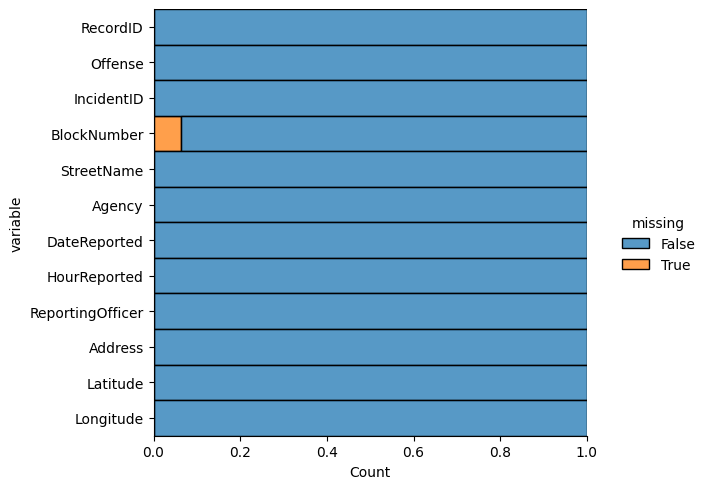

In [ ]:
import seaborn as sns

sns.displot(
    data=crime_data.isna().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    aspect=1.25
)

Investigating the null values further, it looks like it's Block Number that's missing. That's fine because we will train using the latitude and longitude values.

#Data Visualization

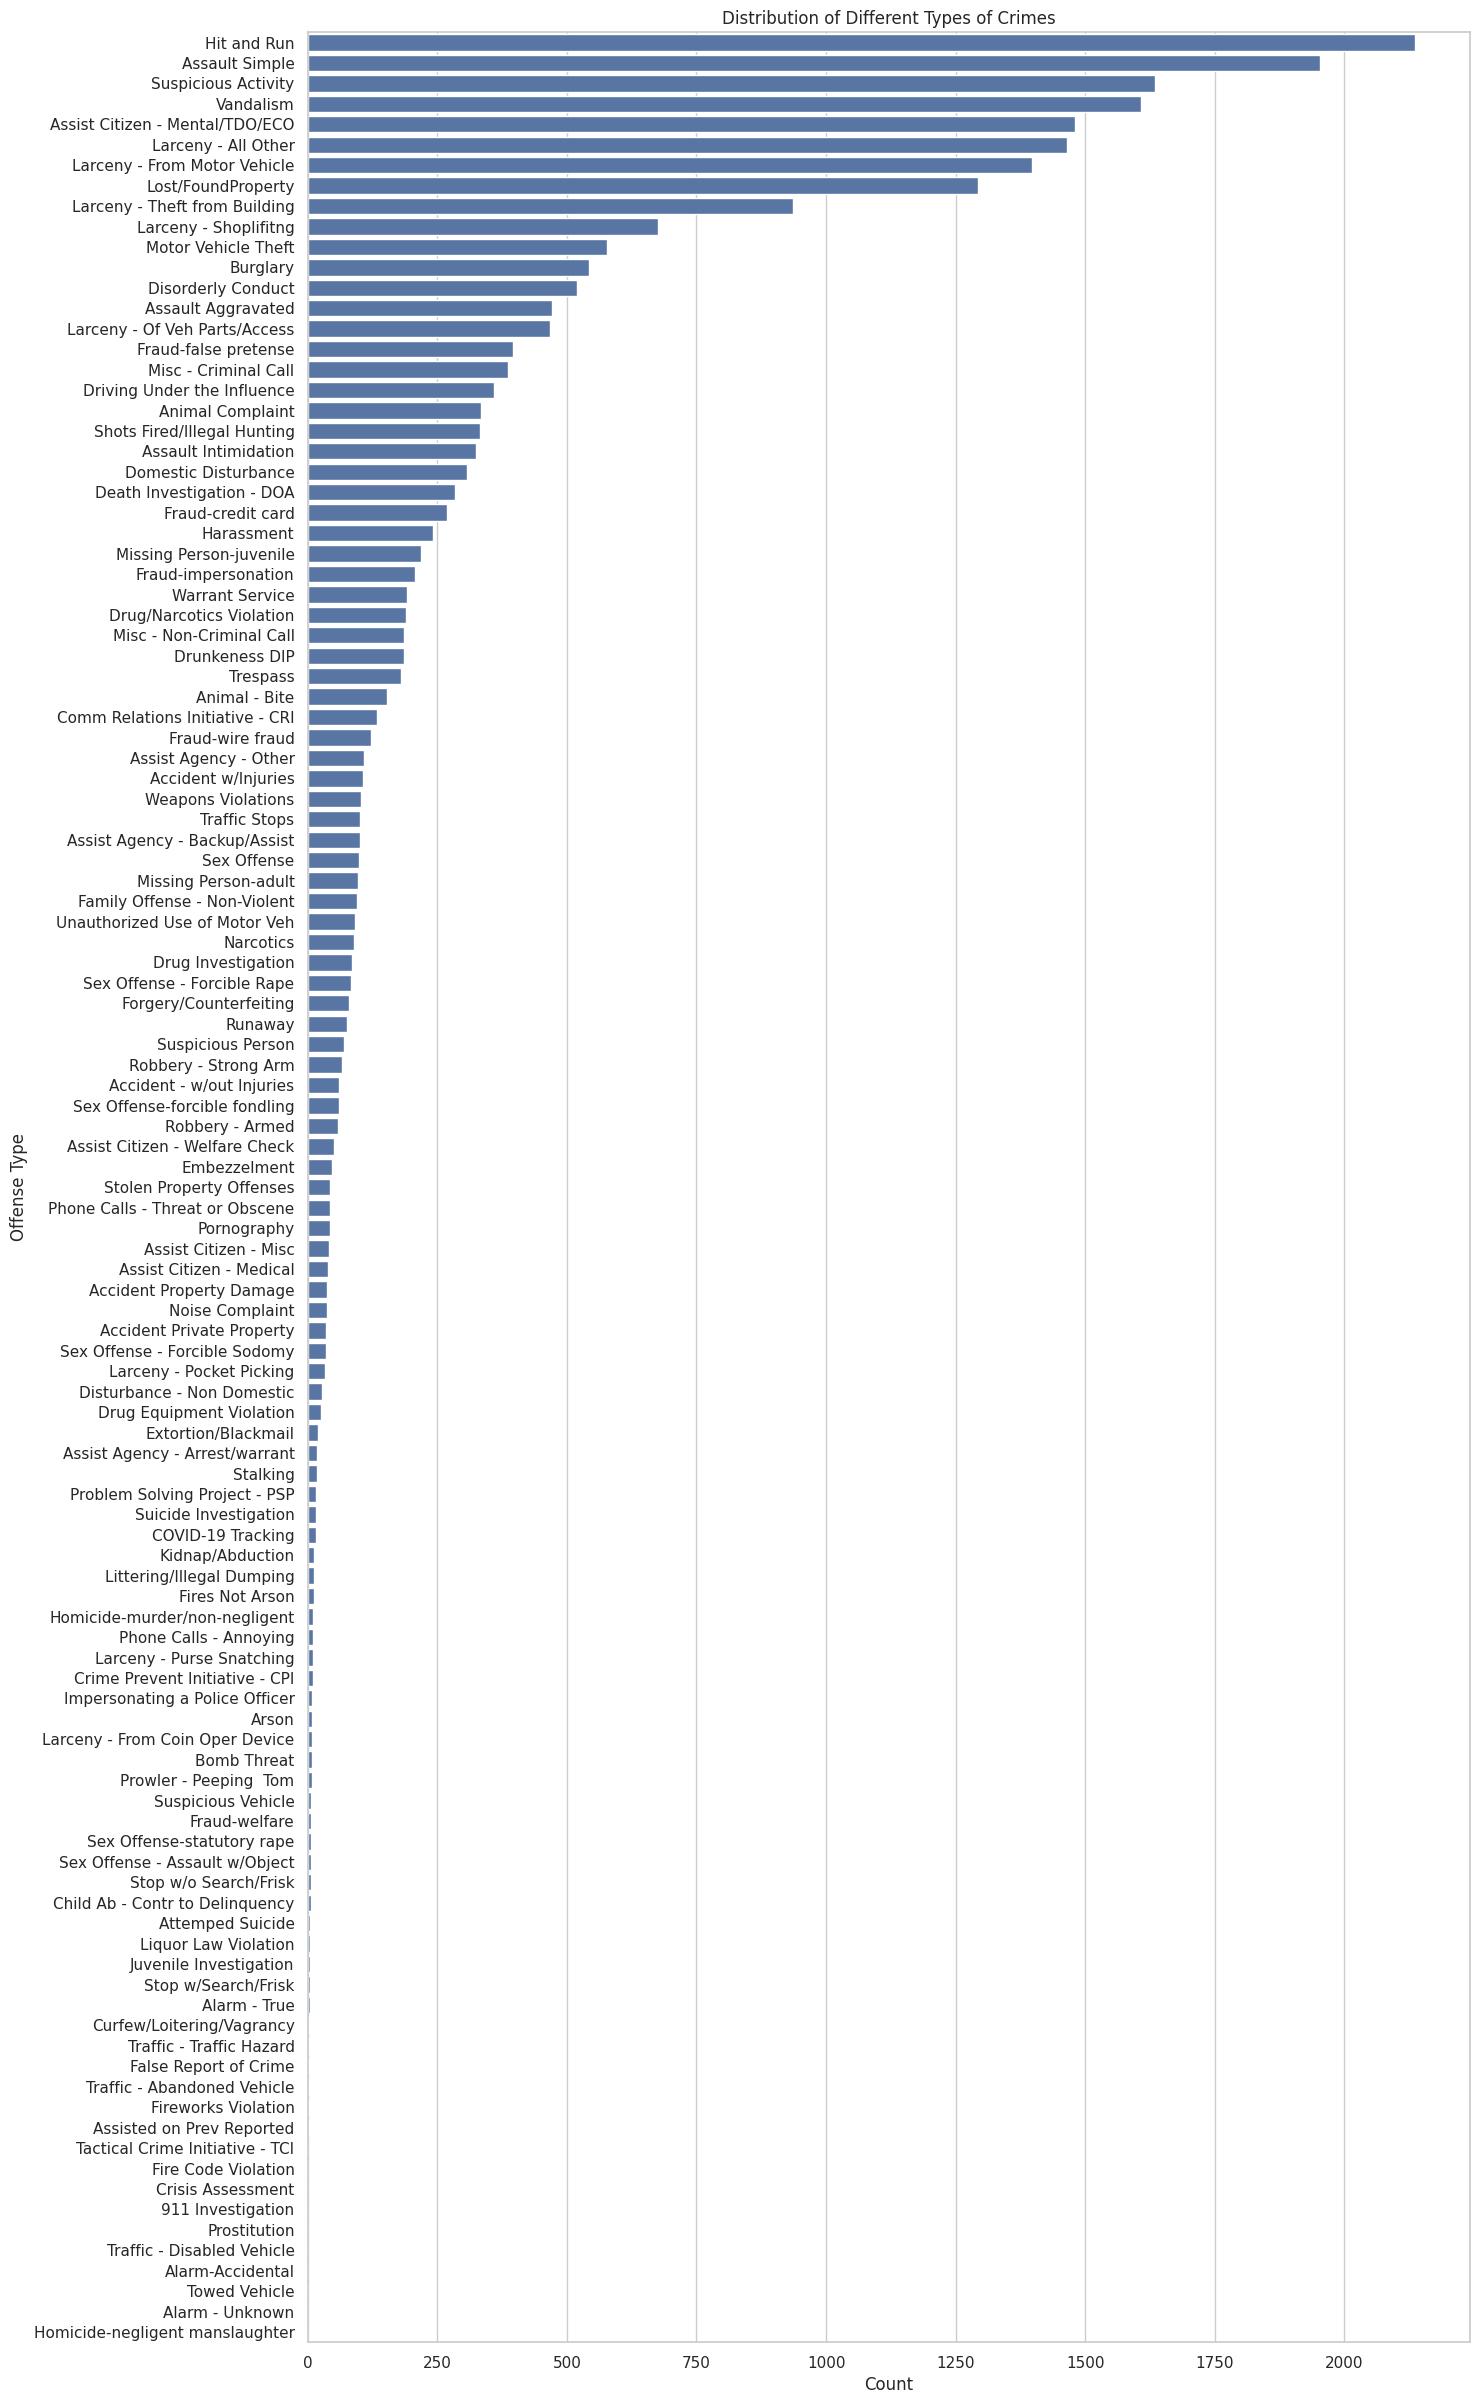

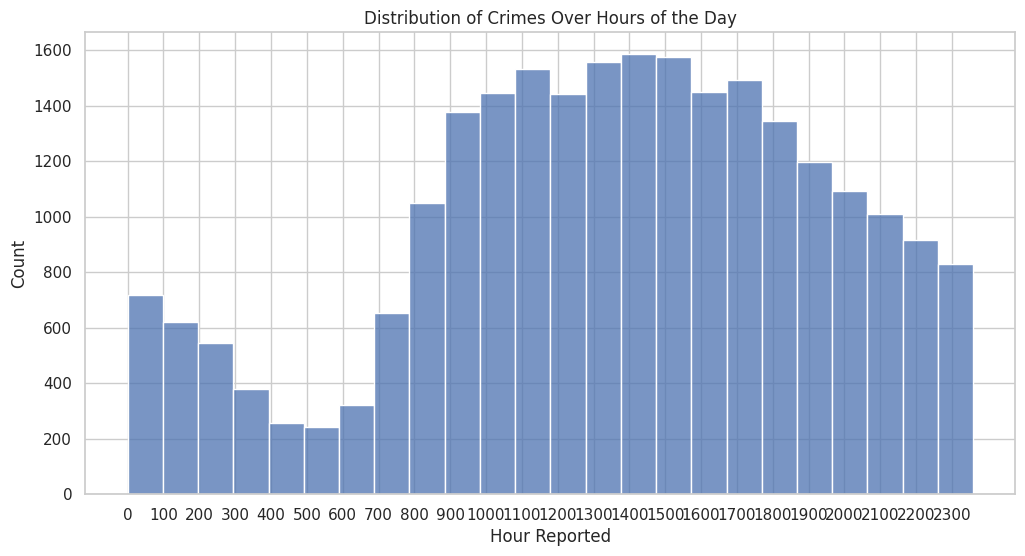

In [ ]:
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# 1. Distribution of different types of crimes
plt.figure(figsize=(15, 30))
sns.countplot(y='Offense', data=crime_data, order=crime_data['Offense'].value_counts().index)
plt.title('Distribution of Different Types of Crimes')
plt.xlabel('Count')
plt.ylabel('Offense Type')
plt.show()

# 2. Distribution of crimes over hours of the day
plt.figure(figsize=(12, 6))
sns.histplot(crime_data['HourReported'], bins=24, kde=False)
plt.title('Distribution of Crimes Over Hours of the Day')
plt.xlabel('Hour Reported')
plt.ylabel('Count')
plt.xticks(range(0, 2400, 100))
plt.grid(True)
plt.show()

We visualize the data to observe the most frequent crimes as well as the most frequent hours of the day they're committed.

#Feature Engineering

In [ ]:
#if a crime contains the following keywords we may consider it as a more dangerous crime category: crime against person (violent crime) or crime against property
crime_data['PersonalCrime'] = crime_data['Offense'].str.contains('|'.join(['Assault', 'Domestic', 'Sex Offense', 'Stalking', 'Kidnap', 'Homicide', 'Child Ab'])).astype('category')
crime_data['PropertyCrime'] = crime_data['Offense'].str.contains('|'.join(['Hit and Run', 'Vandalism', 'Robbery', 'Larceny', 'Theft', 'Burglary', 'Stolen', 'Arson'])).astype('category')


In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24632 entries, 0 to 24631
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   RecordID          24632 non-null  int64   
 1   Offense           24632 non-null  object  
 2   IncidentID        24632 non-null  float64 
 3   BlockNumber       23060 non-null  float64 
 4   StreetName        24632 non-null  object  
 5   Agency            24632 non-null  object  
 6   DateReported      24632 non-null  object  
 7   HourReported      24632 non-null  int64   
 8   ReportingOfficer  24596 non-null  object  
 9   Address           24632 non-null  object  
 10  Latitude          24632 non-null  float64 
 11  Longitude         24632 non-null  float64 
 12  PersonalCrime     24632 non-null  category
 13  PropertyCrime     24632 non-null  category
dtypes: category(2), float64(4), int64(2), object(6)
memory usage: 2.3+ MB


# Data Cleaning

In [ ]:
cat = crime_data.select_dtypes(include='object')
crime_data[cat.columns] = cat.astype('category')

In [ ]:
#drop keys and some other featuers: reporting officer is probably unimportant to our question, and the only geographic features we will use are latitude/longitude
crime_data = crime_data.drop(['RecordID', 'IncidentID', 'Agency', 'ReportingOfficer', 'BlockNumber', 'StreetName', 'Address'], axis=1)
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24632 entries, 0 to 24631
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Offense        24632 non-null  category
 1   DateReported   24632 non-null  category
 2   HourReported   24632 non-null  int64   
 3   Latitude       24632 non-null  float64 
 4   Longitude      24632 non-null  float64 
 5   PersonalCrime  24632 non-null  category
 6   PropertyCrime  24632 non-null  category
dtypes: category(4), float64(2), int64(1)
memory usage: 1.4 MB


In [ ]:
from datetime import datetime

date_format = "%Y/%m/%d %H:%M:%S"
crime_data['DateReported'] = crime_data['DateReported'].apply(lambda date: int(datetime.strptime(date.split('+')[0], date_format).timestamp())).astype('int64')

In [ ]:
crime_data.head()

,Offense,DateReported,HourReported,Latitude,Longitude,PersonalCrime,PropertyCrime
0,Hit and Run,1698631868,2211,38.051725,-78.500087,False,True
1,Assault Aggravated,1698622987,1943,38.020802,-78.504222,True,False
2,Domestic Disturbance,1698621870,1924,38.028616,-78.508199,True,False
3,Larceny - Shoplifitng,1698607345,1522,38.037790,-78.489293,False,True
4,Lost/FoundProperty,1698594530,1148,38.039408,-78.497286,False,False


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Identifying numerical and categorical attributes
num_attribs = ['Latitude', 'Longitude', 'DateReported', 'HourReported']
cat_attribs = ['Offense', 'PersonalCrime', 'PropertyCrime']

# Creating numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Creating categorical pipeline
cat_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Full pipeline
full_pipeline_crime = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

# Applying the pipeline to the crime dataset
crime_data_transformed = full_pipeline_crime.fit_transform(crime_data)
crime_data_transformed.shape

(24632, 121)

# Clustering

In [ ]:
import folium
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=50, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(crime_data_transformed)

# Getting the cluster centroids
centroids = kmeans.cluster_centers_

# Extracting the mean and scale for the numerical features from the pipeline
num_mean = full_pipeline_crime.named_transformers_['num'].named_steps['imputer'].statistics_
num_scale = full_pipeline_crime.named_transformers_['num'].named_steps['scaler'].scale_

# Transforming the centroids' numerical part back to the original scale
centroids_original_scale = centroids[:, :len(num_mean)] * num_scale + num_mean

# Creating a DataFrame for easier interpretation
centroids_df = pd.DataFrame(centroids_original_scale, columns=num_attribs)

# Creating a folium map
m = folium.Map(location=[(37.8 + 38.2) / 2, (-78.75 - 78.25) / 2], zoom_start=12)

# Add circles representing centroids on the map
for i, (lat, lon, _, _) in enumerate(centroids_original_scale):
    folium.Circle(
        location=[lat, lon],
        radius=30,
        fill=True,
        fill_opacity=0.5,
        popup=f'Centroid {i+1}'
    ).add_to(m)

# Display the map
display(m)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)

print("Longitude and Latitude of all centroids:")
print(centroids_df[['Latitude', 'Longitude']])


Longitude and Latitude of all centroids:
     Latitude  Longitude
0   38.053803 -78.496967
1   38.053487 -78.497815
2   38.024321 -78.473995
3   38.032978 -78.492480
4   38.023252 -78.474203
5   38.033812 -78.495650
6   38.025241 -78.502957
7   38.936337 -77.046912
8   38.028946 -78.490195
9   38.027583 -78.490406
10  38.029064 -78.492966
11  38.029324 -78.496354
12  38.026586 -78.490381
13  38.033711 -78.492954
14  38.025592 -78.476019
15  38.029820 -78.496465
16  38.024395 -78.476460
17  38.053442 -78.494333
18  38.019755 -78.508844
19  38.035604 -78.496811
20  38.052713 -78.498627
21  38.053874 -78.495456
22  38.051866 -78.499841
23  38.054236 -78.496077
24  38.024489 -78.474104
25  38.024525 -78.474405
26  38.053188 -78.497225
27  38.020339 -78.506946
28  38.023410 -78.503508
29  38.025354 -78.472911
30  38.025330 -78.480559
31  38.019573 -78.505721
32  38.027368 -78.487606
33  38.030356 -78.497453
34  38.023621 -78.478126
35  38.030292 -78.498988
36  38.020507 -78.505782
37  38.02